# Steps and comments

Import functions from modules. "tool" is just name for now, I haven't found a good name for it yet. 

**[functions](https://github.com/dkbrz/GSoC_2018/blob/master/tool/functions.py) **

**[evaluation](https://github.com/dkbrz/GSoC_2018/blob/master/tool/evaluation.py) **

In [1]:
from tool.functions import *
from tool.evaluation import *

**Dependencies**

Dependencies are written in file with functions

In [ ]:
import logging, sys, os, requests, json, re
from collections import Counter 
from math import exp, log10
from itertools import islice
import networkx as nx
import xml.etree.ElementTree as ET
from github import Github           #Github library for downloading dictionaries
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import matplotlib.pyplot as plt     #some evaluation (optional)
from heapdict import heapdict
from tqdm import tqdm_notebook as tqdm   #progress bar (I use notebook function because I work only here)
import random
import numpy as np, scipy.stats as st

## Loading dictionaries

Function creates a folder "dictionaries" and loads all bilingual dictionaries from Apertium Github. For now I delete ces-ces, ita-ita, eus-eu_bis, hbs_HR-hbs_SR, zh_CN-zh_TW manually, because these languages have to be somehow distinguished from each other. EPO-BEL has wrong name (inside it is bel-epo) so this have to be manually changed.

**All dictionaries are on Github**

To load dictionaries, there has to be a file 'secure.json' containing:
```
{
  "USER": "<username>",
  "PASSWORD": "<password>"
}
```

In [2]:
%time download_all_bidixes()

2018-07-05 16:53:20,769 | INFO : Start
2018-07-05 17:00:39,382 | INFO : Finish
Wall time: 7min 20s


This one creates artificially created monolingual dictionaries that contain all bilingual etries for a particular language.

3 min

In [3]:
%time monodix()

2018-07-05 17:04:31,414 | INFO : started
2018-07-05 17:07:53,656 | INFO : finished
Wall time: 3min 22s


**There are some widgets below that can't be showed. It is just tqdm progress bar that is very useful. It will show up if you run the code.**

At this moment bilingual dictionary evaluation formula is:
    
$$ x = \frac 1{ log10( 10 + DictionaryLength )}$$

$$ Dictionary length = BothSides + 0.5 * LR + 0.5 * RL $$

So we don't go below zero as weight of the edge can't be negative

In [4]:
%time preprocessing()


Wall time: 1h 36min 36s


Now we have all we need: dictionaries and some statistical information.

## Working with language pair

Set languages that we want to work with (order like in bidix name)

In [2]:
lang1, lang2 = 'eng','spa'
n = 10

Create a file "language_list" that contains languages we can use in graph in descending order (from more useful to less useful). 

Wall time: 927 ms


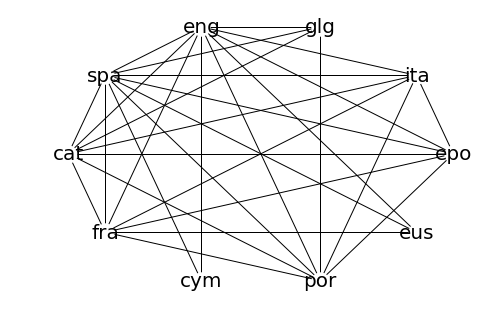

In [3]:
%time get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

In [4]:
%time load_file(lang1, lang2, n=n)
%time change_encoding('{}-{}'.format(lang1,lang2))
%time G = built_from_file('{}-{}'.format(lang1,lang2))
%time l1, l2 = dictionaries(lang1, lang2)

Wall time: 488 ms
Wall time: 761 ms
Wall time: 1min 1s
Wall time: 6.17 s


If we want to check manually, we can search by lemma.

- G: graph
- 'star' : lemma
- l1 : source language dictionary
- 'spa' : target language name
- 4 : cutoff - maximum path length (otherwise search is very slow, this parameter should be equal (or +1) to maximum path length between languages in our top-10 languages)
- 40 : number of closest candidates to evaluate
- n=5 : how many candidates to print

In [5]:
%time print_lemma_results(lemma_search (G, 'star', l1, 'spa', 4, 40), n = 5)

		 eng$star$[vblex]
spa$protagonizar$[vblex]	0.4821836326607207
spa$jugar$[vblex_vblex-vbact]	0.2840371146351084
spa$presentar$[vblex]	0.11074869476740849
spa$constar$[vblex]	0.09727280076923756
spa$tocar$[vblex]	0.0404276819945128

		 eng$star$[n_n-ND]
spa$estrella$[n-f_n_n-f-sg]	2.1957739681949104
spa$estelo$[n-m]	0.2712844579026809
spa$lucero$[n-m_n]	0.2712844579026809
spa$astro$[n_n-m]	0.19526883880421858
spa$estrella$[n-f-ND]	0.1470598691371015

		 eng$star$[adj]
spa$estelar$[adj_adj-mf]	0.1268460281398451
spa$estupendo$[adj-GD_adj-GD-ND]	0.006737946999085467
spa$magnífico$[adj_adj-GD-ND_adj-GD]	0.006737946999085467

Wall time: 290 ms


n_n-ND means that there are different tag combination for this word (n) and (n + ND) that are presumably the same (non contradictory)

Search is an optimized variant of NetworkX single_source_shortest_path_length. When we meet target language node, we stop so this saves some time. Furthermore, we take only n closest variant so this also saves a lot of time.

Formula in this example:

$$\sum_{i=1}^{number of simple paths} \exp^{-len(path_i)}$$

So we sum exponents with degree - length of simple path for all simple paths from source to target node. (And this for all n candidates). Then we sort them in descending order.

Search with larget cutoff takes a lot of time in so dense graph since we have to go furher and check all children in this subgraph

In [7]:
%time s = lemma_search (G, 'casa', l2, 'eng', 4, 40)
%time s = lemma_search (G, 'casa', l2, 'eng', 5, 40)
%time s = lemma_search (G, 'casa', l2, 'eng', 6, 40)

Wall time: 431 ms
Wall time: 2.43 s
Wall time: 15 s


## Evaluation

**How many entries we can add**

Addition says how many entries we can add. (portion of all bilingual entries). I don't know how many make sense, but this number shows how many have at least one candidate (with this cutoff) for translation in other language. 

- exist :  there is a translation in bilingual dictionary
- failed : we can't find any path to target language (at least with this cutoff, with longer paths translation can be worse)
- new : there is at least one candidate for being a translation for some word that has no translation in bilingual dictionary
- errors : word in not in a dictionary (comment below)

In [5]:
addition('eng', 'spa', n=10, cutoff=4)


Exist: 0.12210115829476491, failed: 0.07898593321797302, NEW: 0.062447735984964524, errors: 0.7364651725022976



Exist: 0.21854810247841025, failed: 0.4537990046024532, NEW: 0.1380087727511722, errors: 0.18964412016796434


English has 57 pairs so there could be a large variance in tags and entries. So this number can be explained. But if we take into account that eng dictionary is twice bigger, we get same result (absolute value)

**How good is this instrument in translation prediction**

Loop does 1000 words (or less if dictionary is less than 1000) evaluation n_iter times to get more reliable result. It takes 1000 random words from first language that have only one translation and have at least one translation in some other language and tries to find a translation without this edge between these two nodes.

- 'eng', 'spa' : languages
- n : top-n languages to include in graph
- n: how many iterations we do
- cutoff : max length path

Numbers in parentheses - the boundaries of the confidence interval

** Precision, recall, F1**

We can set topn - which places in sorted result list we consider to be relevant. 

$$ p = \frac{21-topn}{20} $$

topn= 1 would be if we want only 100% bidirectional match.

Result contains all **p** (bidirectional so 0.5 for 1->2 and 0.5 for 2->1)
```
p = p     if place is < topn  #less because 1 is 0 in Python
p = 0.01  if a right one is found but not in topn
```
```
precision = sum(1 for i in result if i >= p) / sum(1 for i in result if i > 0)
recall = sum(1 for i in result if i >= p) / sum(1 for i in result)
f1 = 2 * precision * recall / (precision + recall)
```

In [11]:
lang1, lang2, n = 'eng','spa', 10

** top-5 **

In [3]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=5)

Precision : 0.9558620689655173, recall : 0.693, f1-score : 0.8034782608695653
Precision : 0.9594240837696335, recall : 0.733, f1-score : 0.8310657596371883
Precision : 0.9622395833333334, recall : 0.739, f1-score : 0.8359728506787331

Wall time: 7min 44s


** top-1 ** only 100% match (both sides)

In [4]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=1)

Precision : 0.7328859060402685, recall : 0.546, f1-score : 0.6257879656160459
Precision : 0.7197875166002656, recall : 0.542, f1-score : 0.6183685111237878
Precision : 0.717983651226158, recall : 0.527, f1-score : 0.607843137254902

Wall time: 7min 32s


** We can change cutoffs (slower) and number of languages **

** top-5 **

In [3]:
%time eval_loop(lang1, lang2, n=10, cutoff=6, n_iter=3, topn=5)

Precision : 0.9532967032967034, recall : 0.694, f1-score : 0.8032407407407407
Precision : 0.9554054054054054, recall : 0.707, f1-score : 0.8126436781609194
Precision : 0.9599465954606141, recall : 0.719, f1-score : 0.8221841052029731

Wall time: 8min 1s


In [ ]:
%time eval_loop(lang1, lang2, n=15, cutoff=4, n_iter=3, topn=5)

Precision : 0.9384835479256081, recall : 0.656, f1-score : 0.772218952324897


** top-1 **

In [4]:
%time eval_loop(lang1, lang2, n=10, cutoff=6, n_iter=3, topn=1)

Precision : 0.7281553398058253, recall : 0.525, f1-score : 0.610110400929692
Precision : 0.762619372442019, recall : 0.5669371196754563, f1-score : 0.6503781268179174
Precision : 0.717032967032967, recall : 0.522, f1-score : 0.6041666666666667

Wall time: 6min 15s


In [ ]:
%time eval_loop(lang1, lang2, n=15, cutoff=4, n_iter=3, topn=1)

In [ ]:
%time eval_loop(lang1, lang2, n=15, cutoff=6, n_iter=3, topn=1)

# RUS-UKR

Wall time: 862 ms


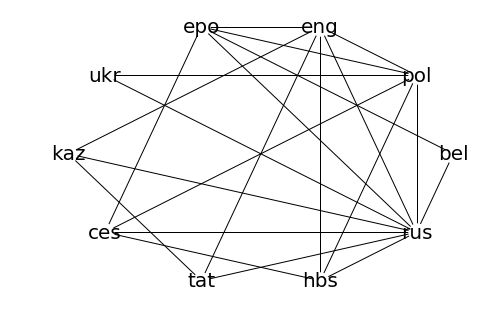

In [3]:
lang1, lang2 = 'rus','ukr'
n = 10
%time get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

Bad results because only alternative (ukr-pol) is only 3k dictionary

In [6]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=5)

Precision : 0.7058823529411765, recall : 0.144, f1-score : 0.23920265780730895
Precision : 0.7047619047619048, recall : 0.148, f1-score : 0.2446280991735537
Precision : 0.7293577981651376, recall : 0.159, f1-score : 0.26108374384236455

Wall time: 3min 31s


In [7]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=1)

Precision : 0.41203703703703703, recall : 0.089, f1-score : 0.1463815789473684
Precision : 0.4398148148148148, recall : 0.095, f1-score : 0.15625
Precision : 0.4772727272727273, recall : 0.105, f1-score : 0.17213114754098363

Wall time: 3min 23s


In [ ]:
addition(lang1, lang2, n=10, cutoff=4)

# RUS-POL

Wall time: 831 ms


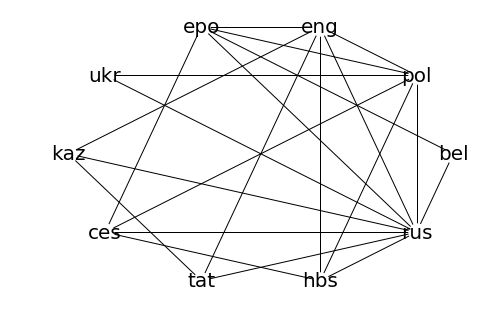

In [8]:
lang1, lang2 = 'pol','rus'
n = 10
%time get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

Rus-Pol is much better

In [9]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=5)

Precision : 0.8559670781893004, recall : 0.416, f1-score : 0.5598923283983849
Precision : 0.8592750533049041, recall : 0.403, f1-score : 0.5486725663716815
Precision : 0.8574468085106383, recall : 0.403, f1-score : 0.5482993197278911

Wall time: 3min 3s


In [10]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=1)

Precision : 0.5906313645621182, recall : 0.29, f1-score : 0.3890006706908115
Precision : 0.6193293885601578, recall : 0.314, f1-score : 0.4167219641672197
Precision : 0.5705765407554672, recall : 0.287, f1-score : 0.38190286094477705

Wall time: 2min 58s


In [ ]:
addition(lang1, lang2, n=10, cutoff=4)

## Weighted edges

I added weighted edges (like in language ranking) but it doesn't seem to work better.

$$ weight[lang1 lang2] =  \frac{1}{log10(10+bidirectional+LR}$$
$$ weight[lang2 lang1] =  \frac{1}{log10(10+bidirectional+RL}$$

I haven't included it in functions yet.

In [1]:
from tool.functions import *
from tool.eval2 import *

In [2]:
lang1, lang2, n = 'eng','spa', 10

In [ ]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=5, metric='exp-len')

In [ ]:
lang1, lang2, n = 'rus','ukr', 10
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=5, metric='exp-len')

In [ ]:
lang1, lang2, n = 'rus','pol', 10
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=5, metric='exp-len')

## How many entries we can possibly add?

In [ ]:
with open('./files/stats.csv', 'r', encoding='utf-8') as inp:
    for line in tqdm(inp.readlines()):
        data = line.split()
        addition2(data[0],data[1])

afr->nld	Exist: 6040, failed: 1312, NEW: 1034 +17.0%, NA: 0
nld->afr	Exist: 5780, failed: 22937, NEW: 3372 +58.0%, NA: 85
ara->heb	Exist: 3027, failed: 3470, NEW: 70 +2.0%, NA: 1
heb->ara	Exist: 2962, failed: 1234, NEW: 27 +1.0%, NA: 1
arg->cat	Exist: 23074, failed: 493, NEW: 2135 +9.0%, NA: 0
cat->arg	Exist: 19160, failed: 60257, NEW: 12044 +63.0%, NA: 15838
asm->ben	Exist: 958, failed: 119, NEW: 1512 +158.0%, NA: 1
ben->asm	Exist: 834, failed: 4448, NEW: 2271 +272.0%, NA: 0
asm->eng	Exist: 2418, failed: 118, NEW: 53 +2.0%, NA: 1
eng->asm	Exist: 2199, failed: 22640, NEW: 1451 +66.0%, NA: 215272
asm->hin	Exist: 822, failed: 428, NEW: 1339 +163.0%, NA: 1
hin->asm	Exist: 718, failed: 35912, NEW: 6299 +877.0%, NA: 1390
ava->rus	Exist: 4066, failed: 0, NEW: 0 +0.0%, NA: 0
rus->ava	Exist: 4558, failed: 5, NEW: 0 +0.0%, NA: 73354
bel->epo	Exist: 4062, failed: 30387, NEW: 13816 +340.0%, NA: 0
epo->bel	Exist: 4312, failed: 47198, NEW: 18752 +435.0%, NA: 111987
bel->rus	Exist: 45450, failed: 76